In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

**Hyperparameters**

In [ ]:
LATENT_DIM = 20
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 1e-3

**Dataset**

In [16]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./train', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./validation', train=False, transform=transform, download=True)

print(f"Dataset téléchargés avec succès, {len(train_dataset)} exemples d'entraînement et {len(val_dataset)} exemples de validation.")

Dataset téléchargés avec succès, 60000 exemples d'entraînement et 10000 exemples de validation.


In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

**VAE architecture**

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Two heads 
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

**Loss Function**

In [19]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

**Instanciation & Training**

In [ ]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [43]:
def train_epoch(model, loader, optimizer):
    losses = []
    for images,_ in loader:
        # Forward pass
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        losses.append(loss.item())

        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

In [44]:
def eval_epoch(model, loader):
    losses = []
    with torch.no_grad():
        for images, _ in loader:
            # Forward pass
            recon_images, mu, logvar = model(images)
            loss = vae_loss(recon_images, images, mu, logvar)
            losses.append(loss.item())
    
    return np.mean(losses)

In [37]:
losses = train_epoch(model, train_loader, optimizer)

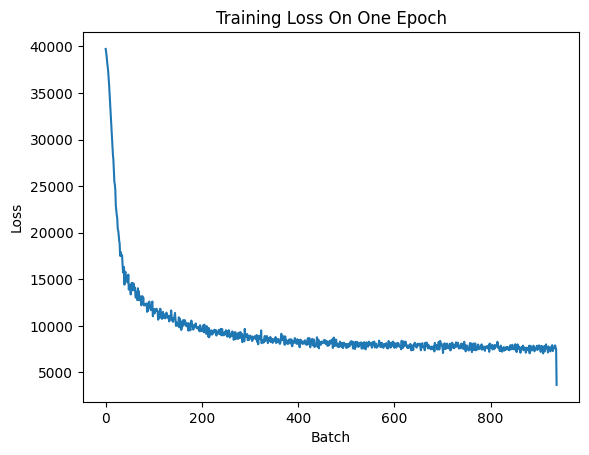

In [38]:
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss On One Epoch')
plt.show()

In [ ]:
def train(model, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS):
    all_losses = []
    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, train_loader, optimizer)   
        avg_epoch_loss = np.mean(epoch_loss)
        val_loss = eval_epoch(model, val_loader)
        print(f"Epoch {epoch + 1} : Train = {avg_epoch_loss:.2f}, Val = {val_loss:.2f}")
        all_losses += epoch_loss
        
    return all_losses

In [48]:
all_losses = train(model, train_loader, val_loader, optimizer)

Epoch 1 : Train = 7267.97, Val = 7022.17
Epoch 2 : Train = 7010.00, Val = 6886.92
Epoch 3 : Train = 6889.19, Val = 6774.28
Epoch 4 : Train = 6815.21, Val = 6727.26
Epoch 5 : Train = 6773.17, Val = 6675.44
Epoch 6 : Train = 6733.04, Val = 6651.50
Epoch 7 : Train = 6698.61, Val = 6634.05
Epoch 8 : Train = 6676.24, Val = 6600.68
Epoch 9 : Train = 6651.26, Val = 6571.27
Epoch 10 : Train = 6629.47, Val = 6563.28


**Images Generation**

In [60]:
def compare_reconstructions(indices, dataset, model):
    model.eval()
    n = len(indices)
    
    fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
    
    # Handle single image case
    if n == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get original image
            img = dataset[idx][0].unsqueeze(0)
            
            # Get reconstruction
            recon, _, _ = model(img)
            
            # Plot original
            img_np = img.squeeze().detach().numpy()
            axes[i, 0].imshow(img_np, cmap='gray')
            axes[i, 0].axis('off')
            if i == 0:
                axes[i, 0].set_title('Original')
            
            # Plot reconstruction
            recon_np = recon.squeeze().detach().numpy()
            axes[i, 1].imshow(recon_np, cmap='gray')
            axes[i, 1].axis('off')
            if i == 0:
                axes[i, 1].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

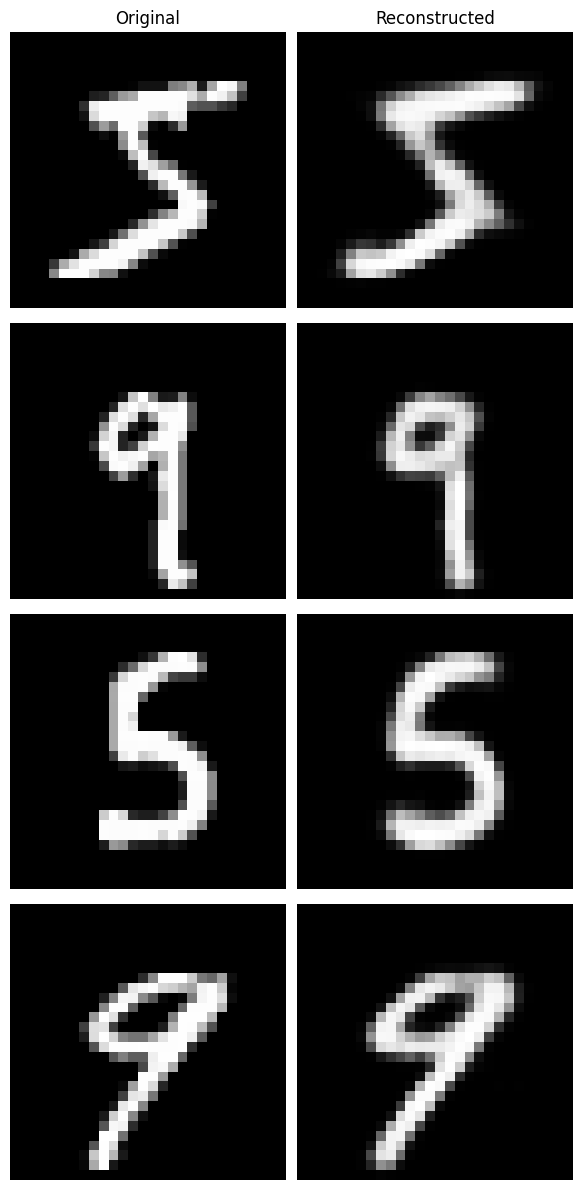

In [65]:
compare_reconstructions([0, 176, 5934, 3987], train_dataset, model)

In [126]:
def image_generation(model):
    # Random Tensor
    z = torch.randn(size=(1, LATENT_DIM))

    # Get Generation
    gen = model.decode(z)

    # Plot
    gen_np = gen.squeeze().detach().numpy()
    plt.imshow(gen_np, cmap='gray')
    plt.axis('off')

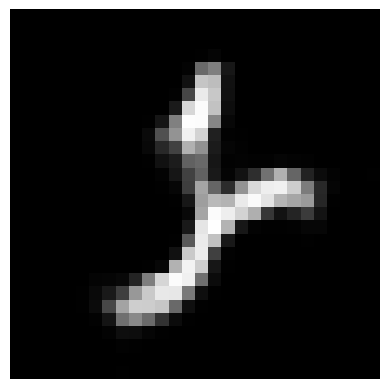

In [136]:
image_generation(model)

In [ ]:
def interpolate(model, dataset, idx1, idx2, N=10):
    # Get tensors
    img1, img2 = dataset[idx1][0].unsqueeze(0), dataset[idx2][0].unsqueeze(0)

    # Get embedded vectors
    (mu1,_),  (mu2, _) = model.encode(img1), model.encode(img2)

    fig, axes = plt.subplots(1, N + 1, figsize=((N + 1) * 2, 2))

    # Interpolation
    alpha = 1 / N
    for i in range(N + 1):
        # Embedded vector between mu1 and mu2
        z = (1 - i * alpha) * mu1 + i * alpha * mu2
        img = model.decode(z)
        img_np = img.squeeze().detach().numpy()

        # Plot
        axes[i].imshow(img_np, cmap='gray')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
        

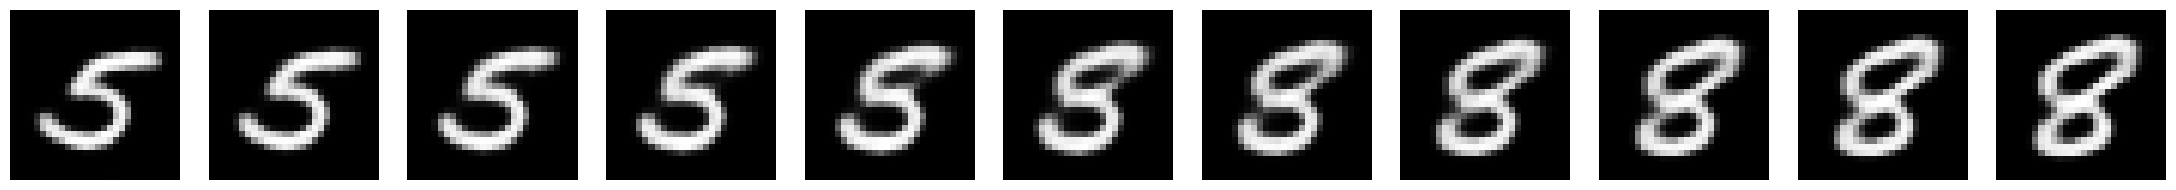

In [134]:
interpolate(model, train_dataset, 239, 9873)